# Single approach - multiple problems to solve

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

This notebook is an adaption of the [Chapter 1](https://github.com/fastai/fastbook) of the "Deep Learning for Coders with fastai and PyTorch: AI Applications Without a PhD" by Jeremy Howard and Sylvain Gugger. If you find this style of learning (bottom -> up) appropriate for you, please check it out!

## 1. Image classification

Ok, let's start with the Cats VS Dogs image classifier. The task is to identify if we have a cat or dog in the image.

You will probably not see exactly the same results that are in the notebook. There are a lot of sources of small random variation involved in training models. We generally see an error rate of well less than 0.02 in this classification example, however.

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.162156,0.033666,0.008796,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.053029,0.008733,0.004060,00:15


In [5]:
# learn.recorder.plot_loss();

Before going throught this code snippet line by line, let's explore the data first. We create dataloader:

In [6]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

And visualize the images (aka `independent variable`, `x`) and corresponding labels (aka `dependent variable`, `y`) which classifier is trained to predict:
> Tip: you can run the following cell several times to see different images.

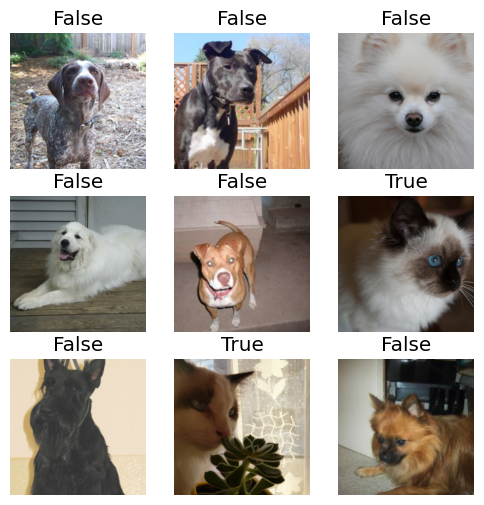

In [10]:
dls.show_batch(max_n=9, nrows=3, figsize=(6,6))

The first line imports all of the fastai.vision library.

```python
from fastai.vision.all import *
```

This gives us all of the functions and classes we will need to create a wide variety of computer vision models.

The second line downloads a standard dataset from the [fast.ai datasets collection](https://docs.fast.ai/data.external.html#datasets) (if not previously downloaded) to your server, extracts it (if not previously extracted), and returns a `Path` object with the extracted location:

```python
path = untar_data(URLs.PETS)/'images'
```

In the third line we define a function, `is_cat`, which labels cats based on a filename rule provided by the dataset creators:
```python
def is_cat(x): return x[0].isupper()
```

In [11]:
!(ls {path}| head -n 6; ls {path} | tail -n 5)

Abyssinian_100.jpg
Abyssinian_100.mat
Abyssinian_101.jpg
Abyssinian_101.mat
Abyssinian_102.jpg
Abyssinian_102.mat
yorkshire_terrier_96.jpg
yorkshire_terrier_97.jpg
yorkshire_terrier_98.jpg
yorkshire_terrier_99.jpg
yorkshire_terrier_9.jpg


We use that function in the fourth line, which tells fastai what kind of dataset we have and how it is structured:

```python
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
```

There are various different classes for different kinds of deep learning datasets and problems—here we're using `ImageDataLoaders`. The first part of the class name will generally be the type of data you have, such as image, or text.

The other important piece of information that we have to tell fastai is how to get the labels from the dataset. Computer vision datasets are normally structured in such a way that the label for an image is part of the filename, or path—most commonly the parent folder name. fastai comes with a number of standardized labeling methods, and ways to write your own. Here we're telling fastai to use the `is_cat` function we just defined.

Finally, we define the `Transform`s that we need. A `Transform` contains code that is applied automatically during training; fastai includes many predefined `Transform`s, and adding new ones is as simple as creating a Python function. There are two kinds: `item_tfms` are applied to each item (in this case, each item is resized to a 224-pixel square), while `batch_tfms` are applied to a *batch* of items at a time using the GPU, so they're particularly fast.

Why 224 pixels? This is the standard size for historical reasons (old pretrained models require this size exactly), but you can pass pretty much anything. If you increase the size, you'll often get a model with better results (since it will be able to focus on more details), but at the price of speed and memory consumption; the opposite is true if you decrease the size.

The Pet dataset contains 7,390 pictures of dogs and cats, consisting of 37 different breeds. Each image is labeled using its filename: for instance the file *great\_pyrenees\_173.jpg* is the 173rd example of an image of a Great Pyrenees breed dog in the dataset. The filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise. We have to tell fastai how to get labels from the filenames, which we do by calling `from_name_func` (which means that labels can be extracted using a function applied to the filename), and passing `is_cat`, which returns `x[0].isupper()`, which evaluates to `True` if the first letter is uppercase (i.e., it's a cat).

The most important parameter to mention here is `valid_pct=0.2`. This tells fastai to hold out 20% of the data and *not use it for training the model at all*. This 20% of the data is called the *validation set*; the remaining 80% is called the *training set*. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly. The parameter `seed=42` sets the *random seed* to the same value every time we run this code, which means we get the same validation set every time we run it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

fastai will *always* show you your model's accuracy using *only* the validation set, *never* the training set. This is absolutely critical, because if you train a large enough model for a long enough time, it will eventually memorize the label of every item in your dataset! The result will not actually be a useful model, because what we care about is how well our model works on *previously unseen images*. That is always our goal when creating a model: for it to be useful on data that the model only sees in the future, after it has been trained.

Even when your model has not fully memorized all your data, earlier on in training it may have memorized certain parts of it. As a result, the longer you train for, the better your accuracy will get on the training set; the validation set accuracy will also improve for a while, but eventually it will start getting worse as the model starts to memorize the training set, rather than finding generalizable underlying patterns in the data. When this happens, we say that the model is *overfitting*.

**Overfitting is the single most important and challenging issue** when training for all machine learning practitioners, and all algorithms. As you will see, it is very easy to create a model that does a great job at making predictions on the exact data it has been trained on, but it is much harder to make accurate predictions on data the model has never seen before. And of course, this is the data that will actually matter in practice. For instance, if you create a handwritten digit classifier (as we will very soon!) and use it to recognize numbers written on checks, then you are never going to see any of the numbers that the model was trained on—checks will have slightly different variations of writing to deal with. You will learn many methods to avoid overfitting in this book. However, you should only use those methods after you have confirmed that overfitting is actually occurring (i.e., you have actually observed the validation accuracy getting worse during training). We often see practitioners using over-fitting avoidance techniques even when they have enough data that they didn't need to do so, ending up with a model that may be less accurate than what they could have achieved.

> important: Validation Set: When you train a model, you must _always_ have both a training set and a validation set, and must measure the accuracy of your model only on the validation set. If you train for too long, with not enough data, you will see the accuracy of your model start to get worse; this is called _overfitting_. fastai defaults `valid_pct` to `0.2`, so even if you forget, fastai will create a validation set for you!

The fifth line of the code training our image recognizer tells fastai to create a *convolutional neural network* (CNN) and specifies what *architecture* to use (i.e. what kind of model to create), what data we want to train it on, and what *metric* to use:

```python
learn = vision_learner(dls, resnet34, metrics=error_rate)
```

Why a CNN? It's a very suitable architecture for vision tasks and still provides state of the art performance in some vision tasks (however ViT - Visual Transformers are taking the lead).

There are many different architectures in fastai, which we will introduce in this book (as well as discussing how to create your own). Most of the time, however, picking an architecture isn't a very important part of the deep learning process. It's something that academics love to talk about, but in practice it is unlikely to be something you need to spend much time on. There are some standard architectures that work most of the time, and in this case we're using one called _ResNet_ that we'll be talking a lot about during the book; it is both fast and accurate for many datasets and problems. The `34` in `resnet34` refers to the number of layers in this variant of the architecture (other options are `18`, `50`, `101`, and `152`). Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

What is a metric? A *metric* is a function that measures the quality of the model's predictions using the validation set, and will be printed at the end of each *epoch*. In this case, we're using `error_rate`, which is a function provided by fastai that does just what it says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for classification is `accuracy` (which is just `1.0 - error_rate`). fastai provides many more, which will be discussed throughout this book.

The concept of a metric may remind you of *loss*, but there is an important distinction. The entire purpose of loss is to define a "measure of performance" that the training system can use to update weights automatically. In other words, a good choice for loss is a choice that is easy for stochastic gradient descent to use. But a metric is defined for human consumption, so a good metric is one that is easy for you to understand, and that hews as closely as possible to what you want the model to do. At times, you might decide that the loss function is a suitable metric, but that is not necessarily the case.

`vision_learner` also has a parameter `pretrained`, which defaults to `True` (so it's used in this case, even though we haven't specified it), which sets the weights in your model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos (using the famous [*ImageNet* dataset](http://www.image-net.org/)). A model that has weights that have already been trained on some other dataset is called a *pretrained model*. You should nearly always use a pretrained model, because it means that your model, before you've even shown it any of your data, is already very capable. And, as you'll see, in a deep learning model many of these capabilities are things you'll need, almost regardless of the details of your project. For instance, parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks.

When using a pretrained model, `vision_learner` will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the *head*.

Using pretrained models is the *most* important method we have to allow us to train more accurate models, more quickly, with less data, and less time and money. You might think that would mean that using pretrained models would be the most studied area in academic deep learning... but you'd be very, very wrong! The importance of pretrained models is generally not recognized or discussed in most courses, books, or software library features, and is rarely considered in academic papers. As we write this at the start of 2020, things are just starting to change, but it's likely to take a while. So be careful: most people you speak to will probably greatly underestimate what you can do in deep learning with few resources, because they probably won't deeply understand how to use pretrained models.

Using a pretrained model for a task different to what it was originally trained for is known as *transfer learning*. Unfortunately, because transfer learning is so under-studied, few domains have pretrained models available. For instance, there are currently few pretrained models available in medicine, making transfer learning challenging to use in that domain. In addition, it is not yet well understood how to use transfer learning for tasks such as time series analysis.

> jargon: Transfer learning: Using a pretrained model for a task different to what it was originally trained for.

The sixth line of our code tells fastai how to *fit* the model:

```python
learn.fine_tune(1)
```

As we've discussed, the architecture only describes a *template* for a mathematical function; it doesn't actually do anything until we provide values for the millions of parameters it contains.

This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at least one piece of information: how many times to look at each image (known as number of *epochs*). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

But why is the method called `fine_tune`, and not `fit`? fastai actually *does* have a method called `fit`, which does indeed fit a model (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels). But in this case, we've started with a pretrained model, and we don't want to throw away all those capabilities that it already has. As you'll learn in this book, there are some important tricks to adapt a pretrained model for a new dataset—a process called *fine-tuning*.

> jargon: Fine-tuning: A transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.

When you use the `fine_tune` method, fastai will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:

1. Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
1. Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).

The *head* of a model is the part that is newly added to be specific to the new dataset. An *epoch* is one complete pass through the dataset. After calling `fit`, the results after each epoch are printed, showing the epoch number, the training and validation set losses (the "measure of performance" used for training the model), and any *metrics* you've requested (error rate, in this case).

## 2. Image segmentation

### 2.1. Problem definition

**Image segmentation** is the process of partitioning a digital image into multiple image segments, also known as image regions or image objects (sets of pixels).

### 2.2. Dataset

The Cambridge-driving Labeled Video Database ([CamVid](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/)) is the first collection of videos with object class semantic labels, complete with metadata. The database provides ground truth labels that associate each pixel with one of 32 semantic classes.



![CamVid example](img/camvid_example.jpg)

### 2.3. Solution

In [14]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

# learn = unet_learner(dls, resnet34)
# learn.fine_tune(8)
learn = unet_learner(dls, resnet34)
learn.freeze()
learn.fit_one_cycle(1)
learn.unfreeze()
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,time
0,3.161015,2.125405,00:01


epoch,train_loss,valid_loss,time
0,1.920209,1.574576,00:01
1,1.751666,1.666116,00:01
2,1.540458,1.190435,00:01
3,1.356727,0.985379,00:01
4,1.205876,0.907847,00:01
5,1.094018,0.890453,00:01
6,1.006970,0.832193,00:01


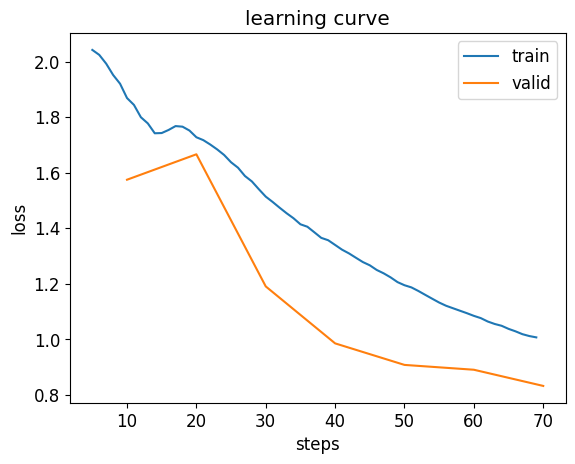

In [15]:
learn.recorder.plot_loss();

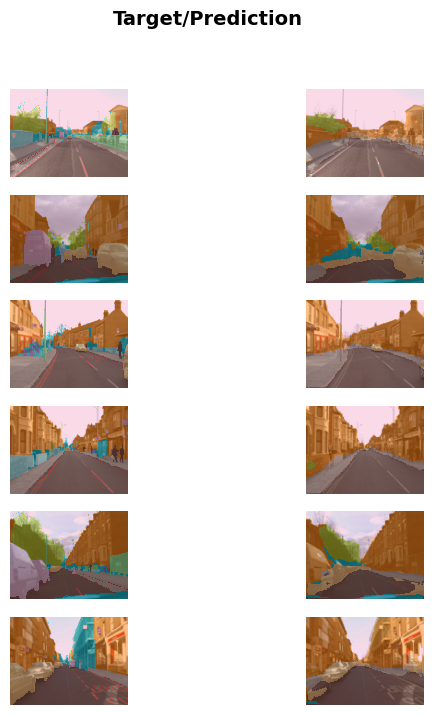

In [16]:
learn.show_results(max_n=6, figsize=(7,8))

## 3. Text classification

### 3.1. Problem definition

**Text Classification** is the task of assigning a label or class to a given text. Some use cases are sentiment analysis, natural language inference, and assessing grammatical correctness.

### 3.2. Dataset

A dataset for binary sentiment classification containing 25,000 highly polarized movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [22]:
from fastai.text.all import *
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
dls.show_batch(max_n=5)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love story is an interesting one , however . xxmaj kate xxmaj winslett is wonderful as xxmaj rose , an aristocratic young lady betrothed by xxmaj cal ( billy xxmaj zane ) . xxmaj early on the voyage xxmaj rose meets xxmaj jack ( leonardo dicaprio ) , a lower class artist on his way to xxmaj america after winning his ticket aboard xxmaj titanic in a poker game . xxmaj if he wants something , he goes and gets it",pos
2,"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxunk "" and "" beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this movie . \n\n "" zombi 3 "" in a bizarre way is actually linked to the infamous xxmaj lucio xxmaj fulci "" zombie "" franchise which began in 1979 . xxmaj similarly compared to "" zombie "" , "" zombi 3 "" consists of a threadbare plot and a handful of extremely bad actors that keeps this ' horror ' trash barely afloat . xxmaj the gore is nearly non - existent ( unless one is frightened of people running around with",neg
3,"xxbos xxmaj polish film maker xxmaj walerian xxmaj borowczyk 's xxmaj la xxmaj bête ( french , 1975 , aka xxmaj the xxmaj beast ) is among the most controversial and brave films ever made and a very excellent one too . xxmaj this film tells everything that 's generally been hidden and denied about our nature and our sexual nature in particular with the symbolism and silence of its images . xxmaj the images may look wild , perverse , "" sick "" or exciting , but they are all in relation with the lastly mentioned . xxmaj sex , desire and death are very strong and primary things and dominate all the flesh that has a human soul inside it . xxmaj they interest and xxunk us so powerfully ( and by our nature ) that they are considered scary , unacceptable and something too wild to be",pos
4,"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ): xxmaj ax is the first to go in seconds when xxmaj warrior splashes him for the pin ( 4 - 3 adv . xxmaj warriors ) . i knew xxmaj ax was n't a healthy man but if he was that unhealthy why bother have him on the card ? xxmaj this would be his last xxup ppv . xxmaj eventually , both xxmaj legion of xxmaj doom and xxmaj demolition job out cheaply via double disqualification ( 2 - 1 adv . xxmaj warriors ) . xxmaj perfect applies",neg


### 3.2. Solution

In [23]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.457666,0.397836,0.820240,00:55


epoch,train_loss,valid_loss,accuracy,time
0,0.313574,0.251094,0.898480,01:48
1,0.245930,0.198707,0.923840,01:49
2,0.192893,0.188012,0.928400,01:48
3,0.142176,0.193107,0.928000,01:46


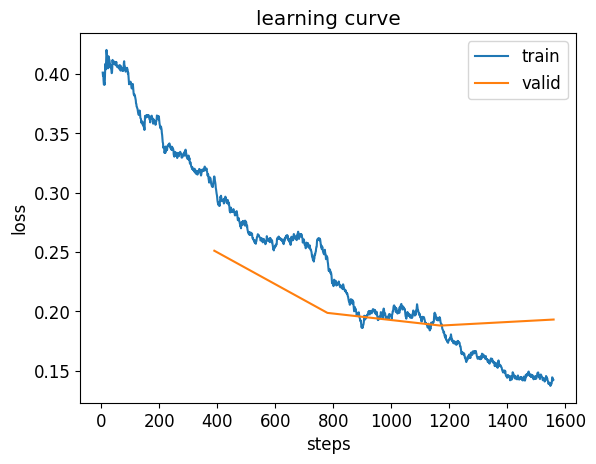

In [24]:
learn.recorder.plot_loss();

Model performs well on straightforward examples:

In [25]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([7.5199e-04, 9.9925e-01]))

In [32]:
learn.predict("It was a waste of time!")

('neg', tensor(0), tensor([9.9945e-01, 5.4551e-04]))

But fails on ones that require the context knowledge.
> In the Harry Potter universe, a dementor is a creature that feeds on human happiness and inflicts feelings of despair and depression. They are described as black, hooded figures, and they are particularly strong in Azkaban prison. A dementor's primary method of attack is the "Dementor's Kiss," which removes a person's soul, leaving them in a vegetative state.

In [28]:
learn.predict("This movie was as good as getting a kiss of Dementor.")

('pos', tensor(1), tensor([0.0107, 0.9893]))

## 4. Tabular data processing

### 4.1 Problem definition

Tabular Data that is in the form of a table, such as from a spreadsheet, database, or CSV file. A tabular model is a model that tries to predict one column of a table based on information in other columns of the table.

### 4.2. Dataset

Link to the dataset: [link](https://archive.ics.uci.edu/dataset/2/adult)

| Variable Name     | Role   | Type        | Demographic      | Description                                                                                                                                                                     | Units | Missing Values |
|------------------|--------|-------------|------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------|----------------|
| age              | Feature| Integer     | Age              | N/A                                                                                                                                                                             |        | no             |
| workclass        | Feature| Categorical | Income           | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.                                                                         |        | yes            |
| fnlwgt           | Feature| Integer     |                  |                                                                                                                                                                                 |        | no             |
| education        | Feature| Categorical | Education Level  | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.                         |        | no             |
| education-num    | Feature| Integer     | Education Level  |                                                                                                                                                                                 |        | no             |
| marital-status   | Feature| Categorical | Other            | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.                                                                    |        | no             |
| occupation       | Feature| Categorical | Other            | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, etc.                   |        | yes            |
| relationship     | Feature| Categorical | Other            | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.                                                                                                            |        | no             |
| race             | Feature| Categorical | Race             | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.                                                                                                                   |        | no             |
| sex              | Feature| Binary      | Sex              | Female, Male.                                                                                                                                                                   |        | no             |
| capital-gain     | Feature| Integer     |                  |                                                                                                                                                                                 |        | no             |
| capital-loss     | Feature| Integer     |                  |                                                                                                                                                                                 |        | no             |
| hours-per-week   | Feature| Integer     |                  |                                                                                                                                                                                 |        | no             |
| native-country   | Feature| Categorical | Other            | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, etc.                              |        | yes            |
| income           | Target | Binary      | Income           | >50K, <=50K.                                                                                                                                                                    |        | no             |


### 4.3. Solution

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [39]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.381003,0.357624,0.830006,00:02
1,0.358999,0.349741,0.841523,00:02
2,0.345834,0.346991,0.841830,00:02


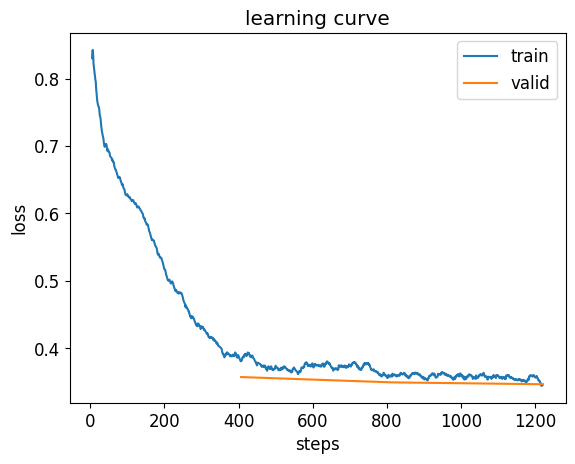

In [41]:
learn.recorder.plot_loss();

## 5. Collaborative filtering - recommendation systems

### 5.1. Problem definition

**Collaborative filtering** is a technique used in recommender systems that recommends items to users based on how other users with similar preferences have interacted with those items. It works by identifying users with similar tastes and using their ratings or purchase history to predict what the target user might like. 

### 5.2. Dataset

Recommendation systems are very important, particularly in e-commerce. Companies like Amazon and Netflix try hard to recommend products or movies that users might like. Here's how to train a model that will predict movies people might like, based on their previous viewing habits, using the [MovieLens dataset](https://doi.org/10.1145/2827872).

### 5.3. Solution

In [42]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.532245,1.428171,00:00


epoch,train_loss,valid_loss,time
0,1.378536,1.371396,00:00
1,1.225556,1.210195,00:00
2,1.041059,0.892236,00:00
3,0.816745,0.730397,00:00
4,0.699720,0.672235,00:00
5,0.658204,0.654888,00:00
6,0.614085,0.646410,00:00
7,0.622834,0.641672,00:00
8,0.607962,0.640765,00:00
9,0.598535,0.640539,00:00


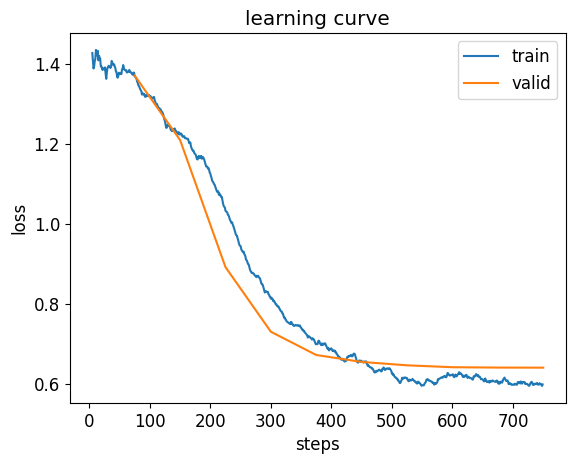

In [43]:
learn.recorder.plot_loss();

In [44]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,80.0,89.0,3.0,3.586507
1,15.0,78.0,2.5,3.257134
2,2.0,54.0,4.5,4.320371
3,94.0,72.0,3.5,3.209172
4,80.0,37.0,1.0,3.430347
5,8.0,10.0,1.0,2.153932
6,86.0,79.0,3.5,3.681948
7,79.0,47.0,5.0,4.783849
8,92.0,14.0,4.5,4.477659
